# DL without Pytorch nn.Module

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [26]:
def get_dls():
    def get_ds(train_valid):
        def get_X(train_valid, three_seven):
            files = (path/train_valid/three_seven).ls()
            X = torch.stack([tensor(Image.open(x)) for x in files])#.reshape(-1, 28*28)
            return X
        X3, X7 = get_X(train_valid, '3'), get_X(train_valid, '7')
        X = torch.cat([X3, X7])/255.
        y = torch.tensor([1]*len(X3) + [0]*len(X7)).reshape(-1, 1)
        #print(X.shape, y.shape)
        return list(zip(X, y))
    ds1 = DataLoader(get_ds('train'), bs=256, shuffle=True)
    ds2 = DataLoader(get_ds('valid'), bs=256)
    return DataLoaders(ds1, ds2)
                    
dls = get_dls()    

In [25]:
def loss_fn(y, t):
    return torch.where(t==1, 1-y, y).mean()

def batch_accuracy(y, t):
    return ((y>0.5)==t).float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb.reshape(-1, 28*28)), yb) for xb,yb in dls.valid]
    return round(torch.stack(accs).mean().item(), 4)

class BasicOptim:
    def __init__(self,params, lr):
        self.params = list(params)
        self.lr = lr

    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [23]:
W = torch.randn(28*28, 1).requires_grad_()
b = torch.randn(1).requires_grad_()
params = W, b
def model(X):
    return sigmoid(X@W + b)
opt = BasicOptim(params, lr=0.1)

acc = []
for epoch in range(40):
    for X, t in dls.train:
        y = model(X.reshape(-1, 28*28))
        loss = loss_fn(y, t)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    acc.append(validate_epoch(model))

<AxesSubplot:>

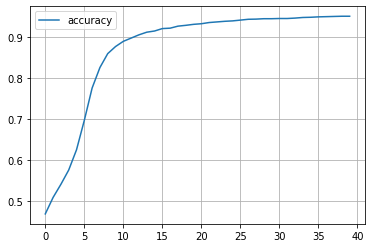

In [24]:
import pandas as pd
pd.DataFrame({'accuracy':acc}).plot(grid=True)